In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.rcParams['font.size']=18
matplotlib.rcParams['xtick.labelsize']=18
matplotlib.rcParams['ytick.labelsize']=18


import numpy as np
import pandas as pd
# import requests
# import urllib.request
# from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
# from sklearn.svm import SVC
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


# from sklearn import model_selection


In [2]:
res=[]
dfAll=pd.DataFrame()
for year in np.arange(2017,2003,-1):
    df=pd.read_csv('data/games/tourn_games_'+str(year)+'.csv',index_col=0)
    dfAll=dfAll.append(df,ignore_index=True)


df2=dfAll.copy()
index=df2.keys()
index
df2.columns=[indx.replace('_1','_xx').replace('_2','_1').replace('_xx','_2') for indx in index]
df2.outcome=1-df2.outcome

dfAll=(df2.append(dfAll))

## Clean dataframe

In [3]:
dropLabels=['outcome', 'region']
dropLabels.append('round')
for t12 in ['1', '2']:
    dropLabels.append('School_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('fullName_'+t12)
    dropLabels.append('Conf_'+t12)
    dropLabels.append('wpct_'+t12)
    dropLabels.append('Rank_'+t12)
    dropLabels.append('WL_'+t12)
    dropLabels.append('sched_url_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('TmPts_'+t12)
    dropLabels.append('OppPts_'+t12)
    dropLabels.append('SRS_'+t12)
#     dropLabels.append('SOS_'+t12)
#     dropLabels.append('seed_'+t12)
    dropLabels.append('AdjEM_'+t12)
    dropLabels.append('AdjEM.1_'+t12)
#     dropLabels.append('AdjO_'+t12)
#     dropLabels.append('AdjD_'+t12)
#     dropLabels.append('AdjT_'+t12)
#     dropLabels.append('Luck_'+t12)
    

In [4]:
dfClean=dfAll.drop(dropLabels,axis=1).dropna(axis=1)
featuresTMP=dfClean.keys()
features=[l.replace('_1','') for l in featuresTMP[::2]]
dfNew=pd.DataFrame()
for lab in features:
    dfNew[lab]=dfClean[lab+'_1']-dfClean[lab+'_2']
    
dfClean=dfNew
features=np.array(sorted(dfClean.columns))
features

array(['3PAr', 'AST%', 'AdjD', 'AdjO', 'AdjT', 'BLK%', 'FT/FGA', 'FTr',
       'Luck', 'NCSOS_AdjEM', 'OppD', 'OppO', 'SOS', 'TOV%', 'TRB%', 'TS%',
       'eFG%', 'seed'],
      dtype='<U11')

# Check various models



## Check vs. seeding

In [5]:
n_fold = 10
test_size = 0.3


Xfeatures=dfClean['seed'].values.reshape(-1,1)

scaler=StandardScaler().fit(Xfeatures)
scaled=scaler.transform(Xfeatures)
X=scaled

y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)


X=X_train
y=y_train

model=RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=2, random_state=0)
model.fit(X_train, y_train)

for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    results = cross_val_score(model, X, y, scoring=scoring)
    print(scoring, ': ', results.mean(), ' +/- ', results.std())
print()
    
c=.2
model = LogisticRegression(C=c,penalty='l1',fit_intercept=True)
model.fit(X_train, y_train)

for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    results = cross_val_score(model, X, y, scoring=scoring)
    print(scoring, ': ', results.mean(), ' +/- ', results.std())
    

roc_auc :  0.762369049074  +/-  0.032535299785
accuracy :  0.694498381877  +/-  0.0144076564981
precision :  0.693079365079  +/-  0.0116490202361
recall :  0.730670064682  +/-  0.0548060940388

roc_auc :  0.782136490974  +/-  0.0220613142948
accuracy :  0.713118636041  +/-  0.0202380177226
precision :  0.721768750645  +/-  0.0158677974816
recall :  0.719701034308  +/-  0.0335154321671


## Random Forest

In [6]:
# features=np.delete(features,np.where(features=='seed')[0])

In [7]:
scaler=StandardScaler().fit(dfClean)
scaled=scaler.transform(dfClean)
X=scaled

X[1,:]


array([ 0.3844388 ,  0.5898716 ,  1.56581899,  0.25990363,  1.16460384,
       -0.70187457,  1.86849791,  1.86849791,  0.91725251, -1.104788  ,
        0.2880755 , -0.14266471, -0.14697528,  0.52629793, -1.84805365,
        1.78199884,  1.30470379,  0.1312936 ])

In [8]:
dfClean.iloc[1]

3PAr            0.028
AST%            4.100
AdjD           11.400
AdjO            2.200
AdjT            5.000
BLK%           -2.800
FT/FGA          0.089
FTr             0.089
Luck            0.056
NCSOS_AdjEM    -6.690
OppD            1.100
OppO           -0.600
SOS            -1.020
TOV%            1.200
TRB%           -6.500
TS%             0.061
eFG%            0.048
seed            1.000
Name: 1, dtype: float64

In [9]:
n_fold = 10
test_size = 0.3


dfClean=dfClean[features]

scaler=StandardScaler().fit(dfClean)
scaled=scaler.transform(dfClean)
X=scaled

y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)


X=X_train
y=y_train

randFor=RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
randFor.fit(X_train, y_train)

for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    results = cross_val_score(randFor, X, y, scoring=scoring)
    print(scoring, ': ', results.mean(), ' +/- ', results.std())
    
    


roc_auc :  0.826601520075  +/-  0.031175497457
accuracy :  0.748733128108  +/-  0.0341309400674
precision :  0.759075646576  +/-  0.0331230381145
recall :  0.749560344571  +/-  0.0339499863651


## Logistic regression

In [79]:
n_fold = 10
test_size = 0.3


dfClean=dfClean[features]

scaler=StandardScaler().fit(dfClean)
scaled=scaler.transform(dfClean)
X=scaled

y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)


X=X_train
y=y_train

c=.2
logReg = LogisticRegression(C=c,penalty='l1',fit_intercept=True)
logReg.fit(X_train, y_train)

kfold = KFold(n_splits=n_fold, random_state=10)


scoring = 'roc_auc' #['accuracy','precision']
for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    results = cross_val_score(logReg, X, y, scoring=scoring)
    print(scoring, ': ', results.mean(), ' +/- ', results.std())

results = cross_val_score(logReg, X, y, scoring=scoring)    
    

roc_auc :  0.881365883525  +/-  0.0182117702082
accuracy :  0.803046807167  +/-  0.02281518956
precision :  0.806080430225  +/-  0.0274715950735
recall :  0.814189692688  +/-  0.0298165001424


In [80]:
logReg.get_params()

{'C': 0.2,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [81]:
predProbs = np.matrix(logReg.predict_proba(X_train))

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack((np.ones((X_train.shape[0],1)), X))

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.matrix(np.zeros(shape = (X_design.shape[0], X_design.shape[0])))
np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]))

# Covariance matrix
covLogit = np.linalg.inv(X_design.T * V * X_design)
# print ("Covariance matrix: ", covLogit)

# Standard errors
# print ("Standard errors: ", np.sqrt(np.diag(covLogit)))

# Wald statistic (coefficient / s.e.) ^ 2
logitParams = np.insert(logReg.coef_, 0, logReg.intercept_)
print ("Wald statistics: ", ((logitParams / np.sqrt(np.abs(np.diag(covLogit)))) ** 2 > 1).sum())
wald = (logitParams / np.sqrt(np.abs(np.diag(covLogit)))) ** 2 
features[np.where((logitParams / np.sqrt(np.abs(np.diag(covLogit)))) ** 2 > 2)[0]-1]

Wald statistics:  7


array(['AST%', 'AdjD', 'AdjO', 'Luck', 'NCSOS_AdjEM', 'OppO', 'seed'],
      dtype='<U11')

In [82]:
features[np.where(logReg.coef_!=0)[1]]
len(features[np.where(logReg.coef_!=0)[1]])
features[np.where(logReg.coef_==0)[1]]
# features

array(['3PAr', 'BLK%', 'SOS', 'TS%', 'eFG%'],
      dtype='<U11')

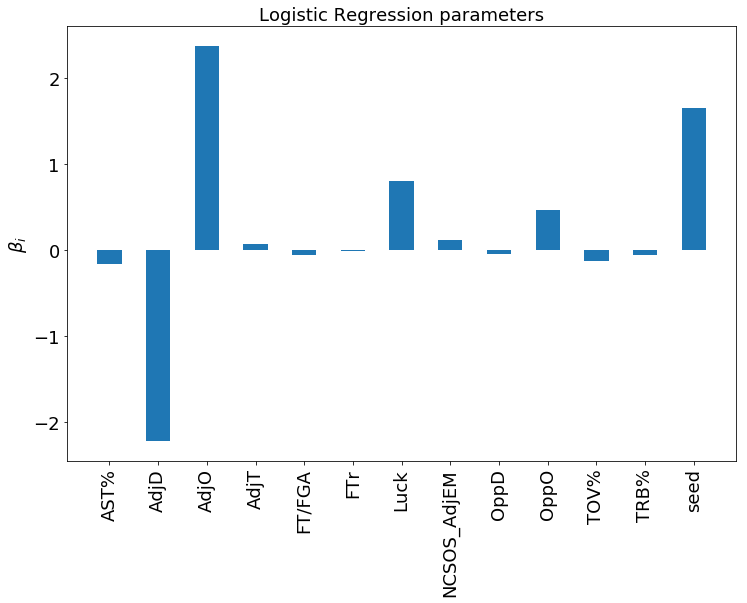

In [83]:
ndata=(logReg.coef_!=0).sum()
indx=np.where((logReg.coef_!=0))[1]

plt.bar(np.arange(ndata), logReg.coef_[0][indx],width=0.5)
labels=dfClean.keys()[indx];
plt.xticks(np.arange(ndata), labels, rotation='vertical');
plt.gca().tick_params(labelsize=18)
plt.title('Logistic Regression parameters',size=18);
plt.ylabel('$\\beta_i$',size=18);

# plt.x

In [84]:
labels

Index(['AST%', 'AdjD', 'AdjO', 'AdjT', 'FT/FGA', 'FTr', 'Luck', 'NCSOS_AdjEM',
       'OppD', 'OppO', 'TOV%', 'TRB%', 'seed'],
      dtype='object')

In [85]:
labels

Index(['AST%', 'AdjD', 'AdjO', 'AdjT', 'FT/FGA', 'FTr', 'Luck', 'NCSOS_AdjEM',
       'OppD', 'OppO', 'TOV%', 'TRB%', 'seed'],
      dtype='object')

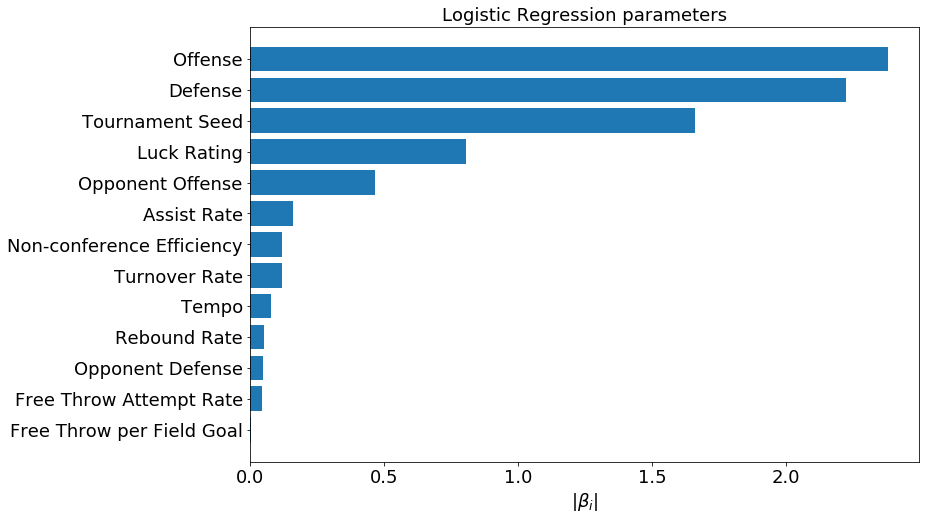

In [86]:
labels=['Offense','Defense','Tournament Seed','Luck Rating','Opponent Offense','Assist Rate','Non-conference Efficiency','Turnover Rate','Tempo','Rebound Rate','Opponent Defense','Free Throw Attempt Rate','Free Throw per Field Goal']


indx=np.where((logReg.coef_!=0))[1]

indxSort=np.argsort(-np.abs(logReg.coef_[0][indx]))
indx=indx[indxSort]
ndata=len(indx)

plt.barh(np.arange(ndata), np.abs(logReg.coef_[0][indx]))
# labels=dfClean.keys()[indx];

# plt.ticks(np.arange(ndata), labels, rotation='vertical');
ax=plt.gca()
ax.tick_params(labelsize=18)
ax.invert_yaxis()
ax.set_yticks(range(ndata))
ax.set_yticklabels(labels)
plt.title('Logistic Regression parameters',size=18);
plt.xlabel('$| \\beta_i |$',size=18);

# plt.x

## Traditional Pythagoean win percentage with log5 

In [26]:
def pythag(pf,pa,exp=11.5):
    return (pf**exp)/(pa**exp+pf**exp)

def pythagGame(df_game,exp=11.5):
    p={}
    for iteam in np.arange(1,3):
        pf = df_game['AdjO_'+str(iteam)]
        pa = df_game['AdjD_'+str(iteam)]
        p[str(iteam)] = pythag(pf,pa,exp)
        
    return p['1']*(1.-p['2'])/(p['1']+p['2']-2.*p['1']*p['2'])
    

# Combine LogReg and Random Forest

In [75]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [76]:
svc = SVC(kernel='rbf', probability=True)
svc.fit(X,y)


nb = GaussianNB()
nb.fit(X,y)

GaussianNB(priors=None)

In [77]:
for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    for clf, label in zip([logReg, randFor, nb, ensemble], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
        scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
        print("%s: %0.2f (+/- %0.2f) [%s]" % (scoring, scores.mean(), scores.std(), label))
    print ()

roc_auc: 0.89 (+/- 0.02) [Logistic Regression]
roc_auc: 0.83 (+/- 0.02) [Random Forest]
roc_auc: 0.82 (+/- 0.01) [naive Bayes]
roc_auc: 0.87 (+/- 0.01) [Ensemble]

accuracy: 0.81 (+/- 0.01) [Logistic Regression]
accuracy: 0.74 (+/- 0.02) [Random Forest]
accuracy: 0.74 (+/- 0.01) [naive Bayes]
accuracy: 0.79 (+/- 0.03) [Ensemble]

precision: 0.82 (+/- 0.02) [Logistic Regression]
precision: 0.75 (+/- 0.03) [Random Forest]
precision: 0.75 (+/- 0.01) [naive Bayes]
precision: 0.80 (+/- 0.03) [Ensemble]

recall: 0.82 (+/- 0.04) [Logistic Regression]
recall: 0.75 (+/- 0.04) [Random Forest]
recall: 0.74 (+/- 0.03) [naive Bayes]
recall: 0.81 (+/- 0.04) [Ensemble]



In [78]:
ensemble=VotingClassifier(estimators=[('logreg', logReg), ('randFor', randFor), ('svc', svc), ('nb', nb)],voting='soft')
ensemble=VotingClassifier(estimators=[('logreg', logReg), ('svc', svc)],voting='soft')
ensemble.fit(X,y)
for scoring in ['roc_auc' , 'accuracy', 'precision', 'recall']:
    results = cross_val_score(ensemble, X, y, scoring=scoring)
    print(scoring, ': ', results.mean(), ' +/- ', results.std())


roc_auc :  0.864221373455  +/-  0.021411795724
accuracy :  0.786013102849  +/-  0.0276694044413
precision :  0.786227243897  +/-  0.0318959354452
recall :  0.807863125578  +/-  0.0311967936581


# Check ROC AUC

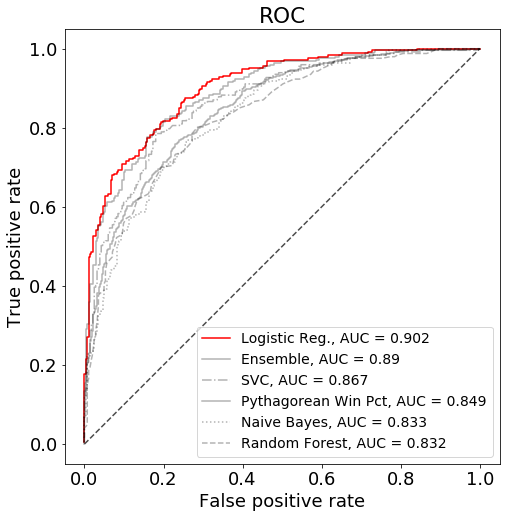

In [86]:
y_predPythag=pythagGame(dfAll)

fpr,tpr,thr=roc_curve(y_test,logReg.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'r',label='Logistic Reg., AUC = '+str(round(roc_auc_score(y_test,logReg.predict_proba(X_test)[:,1]),3)))

fpr,tpr,thr=roc_curve(y_test,ensemble.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,c=[0,0,0,.3],linestyle='-',label='Ensemble, AUC = '+str(round(roc_auc_score(y_test,ensemble.predict_proba(X_test)[:,1]),3)))

fpr,tpr,thr=roc_curve(y_test,svc.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,c=[0,0,0,.3],linestyle='-.',label='SVC, AUC = '+str(round(roc_auc_score(y_test,svc.predict_proba(X_test)[:,1]),3)))

fpr,tpr,thr=roc_curve(dfAll['outcome'],y_predPythag)
plt.plot(fpr,tpr,c=[0,0,0,.3],linestyle='-',label='Pythagorean Win Pct, AUC = '+str(round(roc_auc_score(dfAll['outcome'],y_predPythag),3)))

fpr,tpr,thr=roc_curve(y_test,nb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,c=[0,0,0,.3],linestyle=':',label='Naive Bayes, AUC = '+str(round(roc_auc_score(y_test,nb.predict_proba(X_test)[:,1]),3)))

fpr,tpr,thr=roc_curve(y_test,randFor.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,c=[0,0,0,.3],linestyle='--',label='Random Forest, AUC = '+str(round(roc_auc_score(y_test,randFor.predict_proba(X_test)[:,1]),3)))


plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'--',c=[0,0,0,.7])

plt.legend(prop={'size': 14})
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')

ax=plt.gca()
ax.set_aspect(1)

Text(0,0.5,'Predicted')

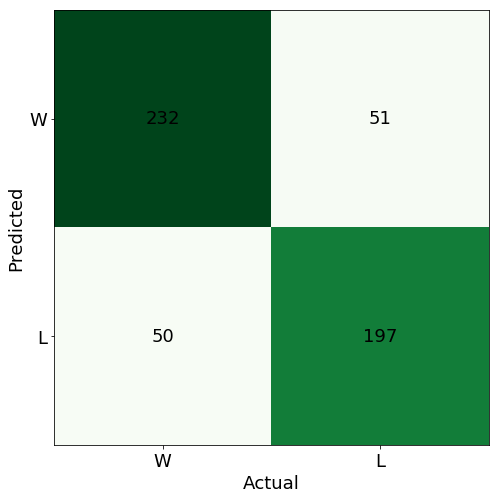

In [13]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
conf_arr=confusion_matrix(y_test,logReg.predict(X_test))
res = plt.imshow(conf_arr,cmap='Greens')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = 'WL'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.xlabel('Actual')
plt.ylabel('Predicted')


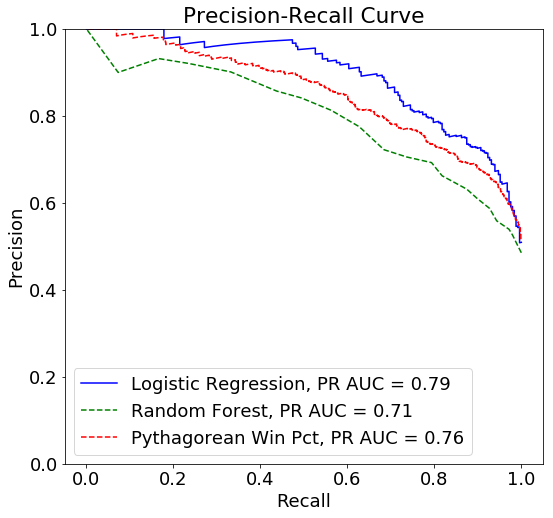

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve, precision_score

precision,recall,thr=precision_recall_curve(y_test,logReg.predict_proba(X_test)[:,1])
plt.plot(recall,precision,'b',label='Logistic Regression, PR AUC = '+
         str(round(precision_score(y_test,logReg.predict_proba(X_test)[:,1]>0.5),2)))

precision,recall,thr=precision_recall_curve(y_test,randFor.predict_proba(X_test)[:,1])
plt.plot(recall,precision,'g--',label='Random Forest, PR AUC = '+
         str(round(precision_score(y_test,randFor.predict_proba(X_test)[:,1]>0.5),2)))

precision,recall,thr=precision_recall_curve(dfAll['outcome'],y_predPythag)
plt.plot(recall,precision,'r--',label='Pythagorean Win Pct, PR AUC = '+str(round(precision_score(dfAll['outcome'],y_predPythag>0.5),2)))


plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.ylim(0,1)
ax=plt.gca()
ax.set_aspect(1)

# Calibration curve

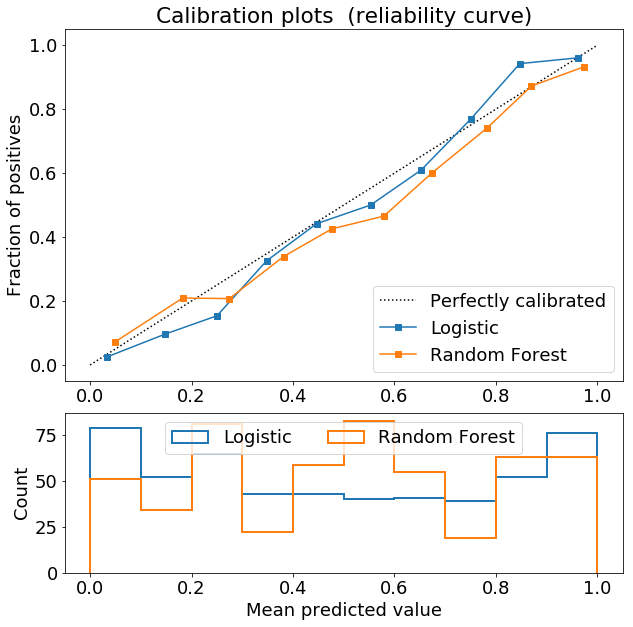

In [98]:
from sklearn.calibration import calibration_curve


plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(logReg, 'Logistic'),
#                   (gnb, 'Naive Bayes'),
#                   (svc, 'Support Vector Classification'),
                  (randFor, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)    

# Dump model and features to file

In [15]:
import pickle
from sklearn.externals import joblib
joblib.dump(logReg, 'app/model.pkl') 
joblib.dump(logReg, './model.pkl') 

features=dfClean.columns
joblib.dump(features,'app/features.pkl')
joblib.dump(features,'./features.pkl')

clf = joblib.load('app/model.pkl') 
featuresX=joblib.load('app/features.pkl')

pickle.dump(scaler, open('app/scaler.pkl', 'wb'))
pickle.dump(scaler, open('./scaler.pkl', 'wb'))



In [16]:
scaler=pickle.load(open('./scaler.pkl','rb'))
scaleX=scaler.transform(dfClean.values)

row=1
print(dfAll.loc[row][['name_1','name_2']].values)
print(clf.predict_proba(X)[row,:])

[['virginia-tech' 'wisconsin']
 ['wisconsin' 'virginia-tech']]
[ 0.67294379  0.32705621]


# Show logistic regression plot

In [58]:
def logit(x):
    return 1./(1.+np.exp(-x))
# logit(X_test.dot(model.coef_.T)).values-model.predict_proba(X_test)[:,1,None]

In [59]:
X_test.shape

(530, 18)

(-5, 5)

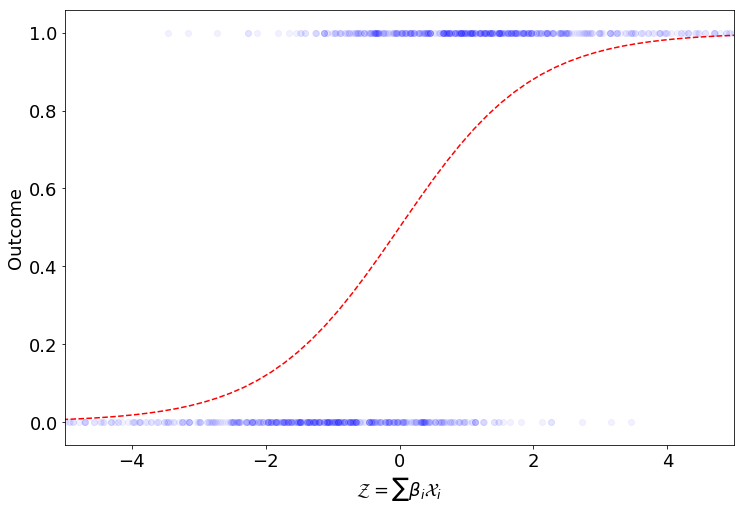

In [60]:
xcoord = X_test.dot(logReg.coef_.T)
plt.scatter(xcoord, y_test,color=[0,0,1,.05])
plt.scatter(-xcoord, 1-y_test,color=[0,0,1,.05])
plt.xlabel('${\cal Z}=\sum \\beta_i {\cal X}_i$',size=18)
plt.ylabel('Outcome',size=18)
plt.gca().tick_params(labelsize=18)

x=np.linspace(-10,10,100)
plt.plot(x,logit(x),'r--')
plt.xlim(-5,5)